# Лабораторная работа 3

## Построение выпуклой оболочки

Разработать программу построения выпуклой оболочки бинарного объекта на основе преобразований утолщения.

Содержание отчета:
- Исходные изображения
- Код программы (для Jupyter Notebook)
- Результат работы программы
- Срок: 15.03.2025

In [120]:
%pylab inline
import skimage.io
from matplotlib.pyplot import imread
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

from scipy.ndimage import binary_erosion, binary_dilation

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def print_images(imgs, *, n_cols=None, fig_dim=None):
    if isinstance(imgs, np.ndarray):
        imgs = [imgs]
    num_imgs = len(imgs)
    if num_imgs == 1:
        n_rows, n_cols = 1, 1
        fig_dim = fig_dim or 5
    else:
        n_cols = n_cols or min(num_imgs, 3)
        n_rows = ceil(num_imgs / n_cols)
        fig_dim = fig_dim or 15
    figsize = (fig_dim, fig_dim / n_cols * n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.atleast_1d(axes).flatten()
    for ax, img in zip(axes, imgs):
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None, interpolation='none')
        ax.axis('off')
    for ax in axes[num_imgs:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

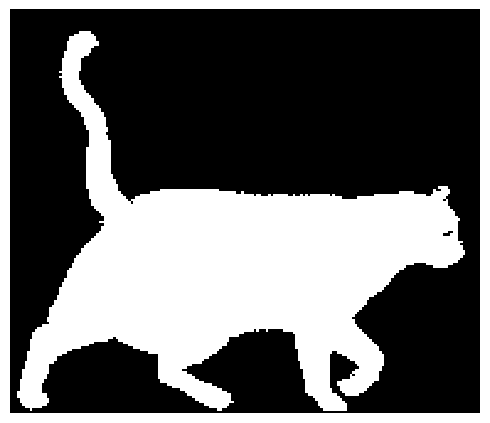

In [117]:
img = (imread('binary.png') > 0.5)
if len(img.shape) == 3:
    img = img[:, :, 0]
print_images(img)

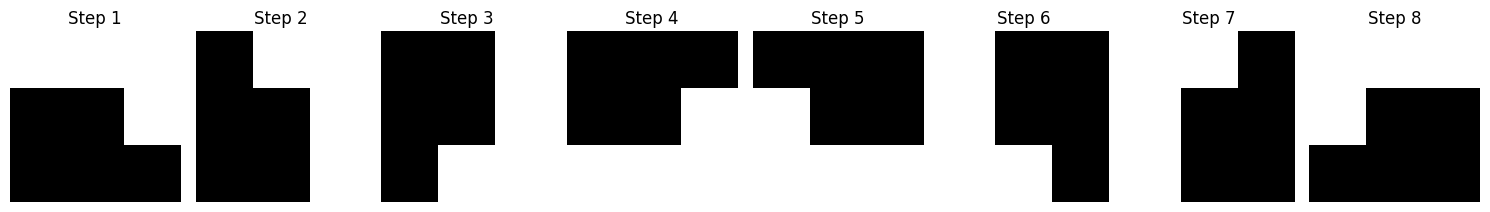

In [ ]:
c = np.array([1] * 4 + [0] * 4, dtype=bool)
perm = [0, 1, 2, 7, 8, 3, 6, 5, 4]
struct_hit = np.array([np.concatenate((np.roll(c, i), [False]))[perm].reshape((3, 3)) for i in range(8)])
struct_miss = np.zeros(9, dtype=bool).reshape(3, 3)
struct_miss[1, 1] = 1

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(struct_hit[i], cmap='gray', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f"Step {i + 1}")

plt.tight_layout()
plt.show()


In [ ]:
from numpy import  invert

def thicken(img, hit, miss):
    """Applies the hit-and-miss transform to thicken the image."""
    img_hit = binary_erosion(img, hit)
    img_miss = binary_erosion(invert(img), miss)
    return np.clip(img + img_hit * img_miss, 0, 1)

def thick_step(img, struct_hit, struct_miss):
    """Performs a single thinning step with all structuring elements."""
    for hit in struct_hit:
        img = thicken(img, hit, struct_miss)
    return img

def convexize(img, struct_hit, struct_miss):
    """Repeatedly applies thickening steps until convergence."""
    prev_img = np.zeros_like(img)
    while not np.array_equal(img, prev_img):
        prev_img = img.copy()
        img = thick_step(img, struct_hit, struct_miss)
    return img


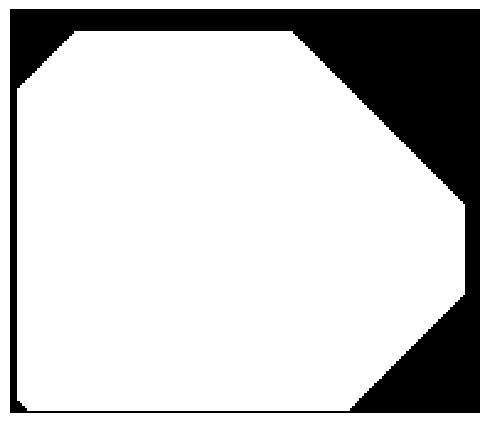

In [ ]:
convex = convexize(img, struct_hit, struct_miss)
print_images(convex)
imsave('skeleton-thick.png', convex)